In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:

# Generate dummy data
def generate_data(num_samples, seq_len, vocab_size):
    data = []
    for _ in range(num_samples):
        src = [random.randint(1, vocab_size-1) for _ in range(seq_len)]
        tgt = src[::-1]  # Reverse the source sequence for the target
        data.append((src, tgt))
    return data

vocab_size = 20
seq_len = 10
num_samples = 1000
data = generate_data(num_samples, seq_len, vocab_size)

class Seq2SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

dataset = Seq2SeqDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(1)
        H = hidden.repeat(max_len, 1, 1).transpose(0, 1)
        attn_energies = self.score(H, encoder_outputs)
        return torch.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedding = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedding)
        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers, attention):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.attention = attention
        self.embedding = nn.Embedding(output_size, embed_size)
        self.lstm = nn.LSTM(hidden_size + embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)
        embedding = self.embedding(x)
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs)
        rnn_input = torch.cat((embedding, context), dim=2)
        outputs, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        predictions = self.fc(outputs.squeeze(1))
        return predictions, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, target_len, target_vocab_size)

        encoder_outputs, hidden, cell = self.encoder(source)

        x = target[:, 0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess

        return outputs


Epoch [1/10], Loss: 2.5766, Accuracy: 0.1851
Epoch [2/10], Loss: 1.9755, Accuracy: 0.3060
Epoch [3/10], Loss: 1.6141, Accuracy: 0.3835
Epoch [4/10], Loss: 1.2185, Accuracy: 0.5220
Epoch [5/10], Loss: 0.9346, Accuracy: 0.6475
Epoch [6/10], Loss: 0.6127, Accuracy: 0.7874
Epoch [7/10], Loss: 0.2612, Accuracy: 0.9300
Epoch [8/10], Loss: 0.1201, Accuracy: 0.9703
Epoch [9/10], Loss: 0.1681, Accuracy: 0.9577
Epoch [10/10], Loss: 0.0407, Accuracy: 0.9926


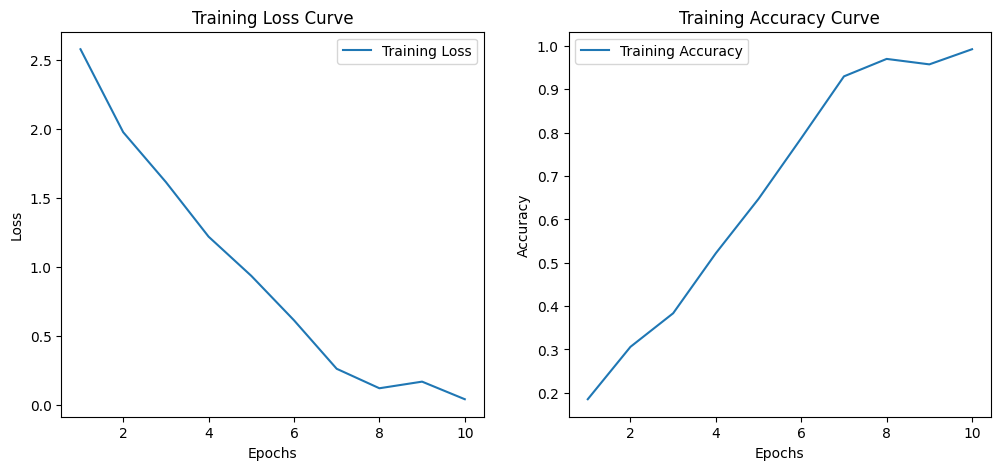

In [ ]:
# Initialize the model
input_size = vocab_size
output_size = vocab_size
embed_size = 256
hidden_size = 512
num_layers = 2

attention = Attention(hidden_size)
encoder = Encoder(input_size, embed_size, hidden_size, num_layers)
decoder = Decoder(output_size, embed_size, hidden_size, num_layers, attention)
model = Seq2Seq(encoder, decoder)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with evaluation metrics
num_epochs = 10
train_losses = []
train_accuracies = []

def calculate_accuracy(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum().item()
    return correct / target.numel()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0

    for i, (src, tgt) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(src, tgt)

        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_accuracy += calculate_accuracy(output, tgt)

    train_losses.append(epoch_loss / len(dataloader))
    train_accuracies.append(epoch_accuracy / len(dataloader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}, Accuracy: {epoch_accuracy / len(dataloader):.4f}')

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()

plt.show()


In [ ]:
# Model evaluation and sample predictions
model.eval()
with torch.no_grad():
    for i, (src, tgt) in enumerate(dataloader):
        output = model(src, tgt, teacher_forcing_ratio=0)
        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        pred = output.argmax(1).view(-1, seq_len-1)
        print(f'Source: {src[0].numpy()}')
        print(f'Target: {tgt.view(-1, seq_len-1)[0].numpy()}')
        print(f'Predicted: {pred[0].numpy()}')
        break


Source: [ 8 12  7 15 18 12  9  8  7  3]
Target: [ 7  8  9 12 18 15  7 12  8]
Predicted: [ 7  8  9 12 18 15  7 12  8]
